<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 4 - Skin Cancer Detection

> Authors: Cher Wee Zheng, Ng Wei, Ryan Yong

**Summary:**   
- Develop a Neural Network model to differentiate whether the skin abnormality in the image is malignant or benign .
- Training data: Malignant and Benign samples

There are a total of 4 notebooks for this project:  
 1. `01_EDA.ipynb`   
 2. `02_Data_Modelling.ipynb`   
 3. `03_Hyperparameter_Tuning.ipynb`

---
**This Notebook**
- In this notebook, the data will be fitted into 4 models, Inception ResNet V2, Hybrid, a custom Sequential CNN and a SVM. The various models will be evaluated with a separate test data set for accuracy and recall. This alongside their processing time will go into the evaluation of the final chosen model.

In [5]:
# Imports for Tensorflow for models 
import tensorflow as tf
from tensorflow.keras.applications.inception_resnet_v2  import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import  preprocess_input as resnet_pp_input

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, Sequential,load_model
from tensorflow.keras.optimizers import Adam

# imports for Scikit learn
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from skimage.io import imread
from skimage.transform import resize

# General imports
import pickle
import numpy as np
import matplotlib.pyplot as plt

import os
import shutil
import math 

Fixed variables across models for consistent comparison

In [8]:
# Set the input image size, number of classes and batch size
img_size = (299, 299)
num_classes = 2
batch_size = 32

The Training data is split into two subdirectories (train_data_dir & validation_data_dir). Subdirectories for them are created

In [31]:
# Set Original Training and Test Directories
train_dir = '../data/train'
test_dir = '../data/test'

# Get the list of subdirectories in the original training directory
subdirectories = os.listdir(train_dir)

# Split the subdirectories into training and validation sets
train_subdirs, validation_subdirs = train_test_split(subdirectories, test_size=0.2, random_state=42)

# Create directories for training and validation data
train_data_dir = '../data/train_data'
os.makedirs(train_data_dir, exist_ok=True)

validation_data_dir = '../data/validation_data'
os.makedirs(validation_data_dir, exist_ok=True)

Code used to filter and separate into the new directories. Cell has been commented out as code does not need to be repeated. Original Training and Test datasets alongside Training and Validation subdirectories will be uploaded on Github.

In [32]:
# # Move images to the corresponding directories
# for subdir in subdirectories:
#     filenames = os.listdir(os.path.join(train_dir, subdir))
#     train_filenames, validation_filenames = train_test_split(filenames, test_size=0.2, random_state=42)
    
#     for filename in train_filenames:
#         src = os.path.join(train_dir, subdir, filename)
#         dst = os.path.join(train_data_dir, subdir, filename)
#         os.makedirs(os.path.dirname(dst), exist_ok=True)
#         shutil.copy(src, dst)

#     for filename in validation_filenames:
#         src = os.path.join(train_dir, subdir, filename)
#         dst = os.path.join(validation_data_dir, subdir, filename)
#         os.makedirs(os.path.dirname(dst), exist_ok=True)
#         shutil.copy(src, dst)

Preprocessing for train_generator & val_generator listed below. For training data, additional augmentations are made to increase image variance and reduce model overfitting.

In [33]:
# Prepare the data generators for training and validation
train_datagen = ImageDataGenerator(preprocessing_function=resnet_pp_input,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=img_size,
                                                    batch_size=batch_size,
                                                    class_mode='binary')

val_generator = val_datagen.flow_from_directory(validation_data_dir,
                                                target_size=img_size,
                                                batch_size=batch_size,
                                                class_mode='binary')

# Evaluate the model
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)
# Print the number of samples in each class for training and validation
print("Number of samples in training set:")
print(train_generator.classes)
print("\nNumber of samples in validation set:")
print(val_generator.classes)
   

Found 9503 images belonging to 2 classes.


Found 2376 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Number of samples in training set:
[0 0 0 ... 1 1 1]

Number of samples in validation set:
[0 0 0 ... 1 1 1]


## Model 1 : Inception ResNetV2

[Inception ResNetV2](https://www.mathworks.com/help/deeplearning/ref/inceptionresnetv2.html) is Residual Network (ResNet) Architecture that is trained on more than a million images from the ImageNet database. The network is 164 layers deep and can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals. ResNetV2 incorporates residual connections (replacing the filter concatenation stage of the Inception architecture).

In [ ]:
resnet_pp_input()

In [6]:
# Load the pre-trained Inception ResNet v2 model
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))

In [35]:
# Add a global average pooling layer and a dense output layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='sigmoid')(x)

# Create the final model
IRNv2_model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
IRNv2_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [36]:
# Train the model
Resnet_history = IRNv2_model.fit(train_generator,
          batch_size =batch_size,
          epochs=10,
          validation_data=val_generator)

Epoch 1/10


c:\Users\Ryany\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


297/297 ━━━━━━━━━━━━━━━━━━━━ 950s 3s/step - accuracy: 0.7757 - loss: 0.5912 - val_accuracy: 0.8582 - val_loss: 0.3421
Epoch 2/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 931s 3s/step - accuracy: 0.8544 - loss: 0.3344 - val_accuracy: 0.8598 - val_loss: 0.3162
Epoch 3/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 931s 3s/step - accuracy: 0.8624 - loss: 0.3114 - val_accuracy: 0.8531 - val_loss: 0.3278
Epoch 4/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 928s 3s/step - accuracy: 0.8751 - loss: 0.2928 - val_accuracy: 0.8657 - val_loss: 0.3011
Epoch 5/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 928s 3s/step - accuracy: 0.8666 - loss: 0.3121 - val_accuracy: 0.8624 - val_loss: 0.3097
Epoch 6/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 927s 3s/step - accuracy: 0.8730 - loss: 0.2975 - val_accuracy: 0.8624 - val_loss: 0.3019
Epoch 7/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 927s 3s/step - accuracy: 0.8760 - loss: 0.2977 - val_accuracy: 0.8481 - val_loss: 0.3491
Epoch 8/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 927s 3s/step - accuracy: 0.8771 - loss: 0.2863 - val_accuracy: 0.866

In [37]:
# Evaluate the model on the test set
test_loss, test_accuracy = IRNv2_model.evaluate(test_generator)

# Print the test accuracy
print("Test Accuracy:", test_accuracy)

63/63 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.9302 - loss: 0.1946
Test Accuracy: 0.8865000009536743


With a validation accuracy of 0.87 and a test Accuracy of 0.88, it would indicate that the model is effective with little to no underfitting.

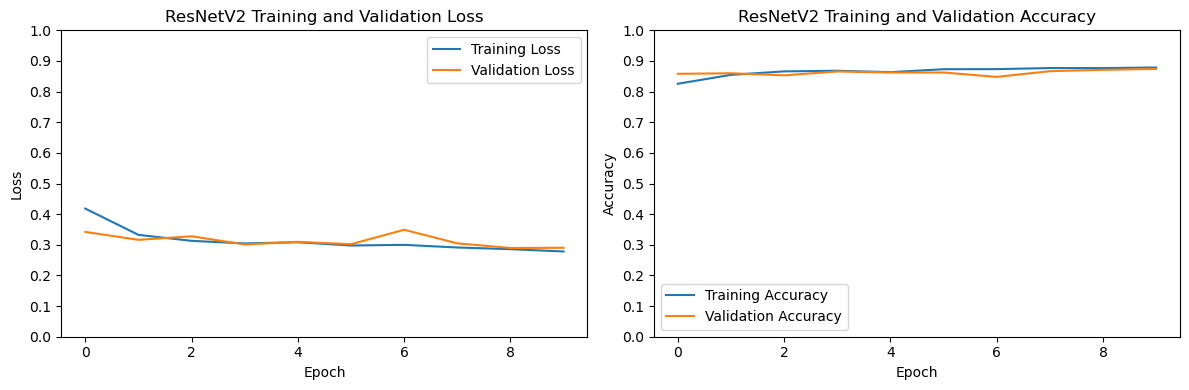

In [38]:
# Plot the training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(Resnet_history.history['loss'], label='Training Loss')
plt.plot(Resnet_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 1)
plt.yticks([i/10 for i in range(11)])
plt.legend()
plt.title('ResNetV2 Training and Validation Loss')

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(Resnet_history.history['accuracy'], label='Training Accuracy')
plt.plot(Resnet_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.yticks([i/10 for i in range(11)])
plt.legend()
plt.title('ResNetV2 Training and Validation Accuracy')

plt.tight_layout()
plt.show()


Training and validation loss/accuracy across Epochs. Model seems to have stabalized after Epoch 4/5, but show some disturbances during Epoch 6, indicating the necessity of 10 Epochs.

In [39]:
# Generate predictions on the validation set
test_generator.reset()
steps = math.ceil(test_generator.samples / test_generator.batch_size)
predictions = IRNv2_model.predict(test_generator, steps=steps)
resnet_predicted_classes = np.argmax(predictions, axis=1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step


check for predicted classes shapes to ensure consistency between prediction and true values for comparison in a Confusion Matrix.

In [40]:
resnet_predicted_classes.shape

(2000,)

In [41]:
# Get the true labels from the validation generator
true_classes = test_generator.classes

true_classes.shape

(2000,)

ResNetV2 Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      1000
           1       0.94      0.82      0.88      1000

    accuracy                           0.89      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.89      0.89      0.89      2000



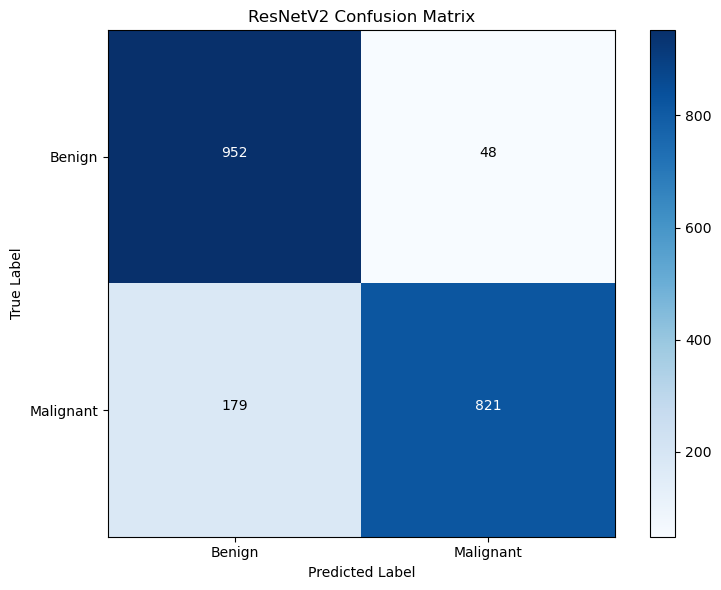

In [42]:

# Print the classification report
print("ResNetV2 Classification Report:")
print(classification_report(true_classes, resnet_predicted_classes))

# Plot the confusion matrix
cm = confusion_matrix(true_classes, resnet_predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('ResNetV2 Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Benign', 'Malignant'])
plt.yticks(tick_marks, ['Benign', 'Malignant'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add the values inside the squares
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

With a test accuracy of 0.89, confusion matrix shows that model is able to highly effectively classify malignant melanoma. However, it has a greater weakness of misclassifying true Malignant images as Benign. 

In [43]:
IRNv2_model.save("ResNetV2_model_v222.h5")
IRNv2_model.save('ResNetV2_model.keras')

## Model 2: Hybrid VGG-16

[VGG-16](https://www.geeksforgeeks.org/vgg-16-cnn-model/#:~:text=The%20VGG%2D16%20model%20is,and%203%20fully%20connected%20layers.) is a Convoluntionary Neural Network (CNN) model developed by the Visual Geometry Group (VGG) in the University of Oxford. It is characterized by the 16 layers it has, 13 of which are convultional layers and the remaining 3 being fully connected layers. VGG-16 is renowned for its simplicity and effectiveness, as well as its ability to achieve strong performance on various computer vision tasks, including image classification and object recognition.  

However, due to some accidental code errors. The output resulted in a base model using inception_resnet_v2 with the outer layers of VGG16. This hybrid model incorporates aspects of both ResNet and VGG-16, making it a hybrid model.

In [9]:
img_size = (224,224)

# Load the pre-trained VGG16 model
VGG_16base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))

# Add custom layers on top of the pre-trained model
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='sigmoid')(x)

# Create the final model
VGG16_model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

VGG16_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [45]:
# Train the model
VGG16_history = VGG16_model.fit(train_generator,
          batch_size = batch_size,
          epochs=10,
          validation_data=val_generator,)

Epoch 1/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 982s 3s/step - accuracy: 0.7768 - loss: 2.6948 - val_accuracy: 0.8497 - val_loss: 0.4352
Epoch 2/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 966s 3s/step - accuracy: 0.8417 - loss: 0.4384 - val_accuracy: 0.8607 - val_loss: 0.3280
Epoch 3/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 960s 3s/step - accuracy: 0.8604 - loss: 0.3478 - val_accuracy: 0.8699 - val_loss: 0.3100
Epoch 4/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 960s 3s/step - accuracy: 0.8677 - loss: 0.3130 - val_accuracy: 0.8632 - val_loss: 0.3089
Epoch 5/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 960s 3s/step - accuracy: 0.8708 - loss: 0.3010 - val_accuracy: 0.8737 - val_loss: 0.3146
Epoch 6/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 987s 3s/step - accuracy: 0.8779 - loss: 0.2876 - val_accuracy: 0.8607 - val_loss: 0.3206
Epoch 7/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 960s 3s/step - accuracy: 0.8736 - loss: 0.2996 - val_accuracy: 0.8742 - val_loss: 0.2889
Epoch 8/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 958s 3s/step - accuracy: 0.8837 - loss: 0.2729 - val_accu

In [46]:
# Generate predictions on the test set
test_generator.reset()
steps = math.ceil(test_generator.samples / test_generator.batch_size)
VGG16_predictions = VGG16_model.predict(test_generator, steps=steps)
VGG16_predicted_classes = np.argmax(VGG16_predictions, axis=1)

# Get the true labels from the test generator
true_classes = test_generator.classes


63/63 ━━━━━━━━━━━━━━━━━━━━ 166s 3s/step


In [47]:
# Evaluate the model on the test set
test_loss, test_accuracy = VGG16_model.evaluate(test_generator)

# Print the test accuracy
print("Test Accuracy:", test_accuracy)

63/63 ━━━━━━━━━━━━━━━━━━━━ 158s 3s/step - accuracy: 0.9187 - loss: 0.2582
Test Accuracy: 0.909500002861023


With similar training and validation accuracy, the hybrid model appears to be fitted well, with a strong test accuracy of 0.91

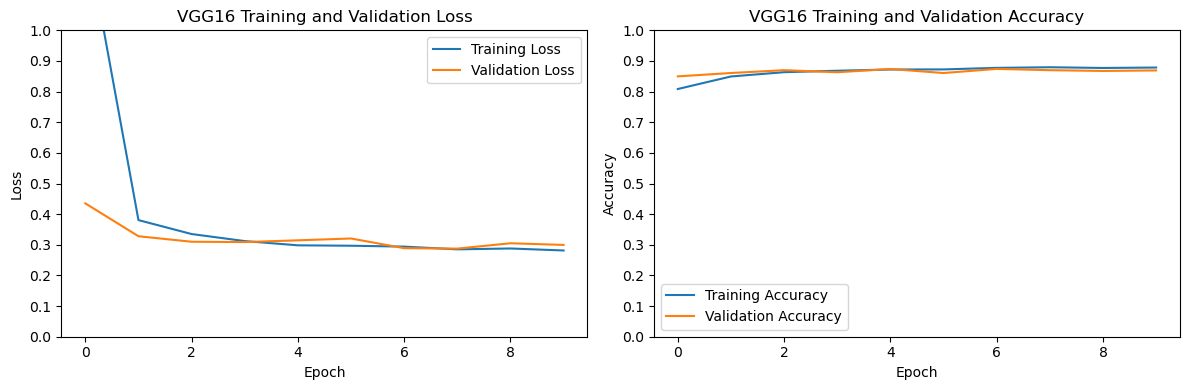

In [48]:
# Plot the training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(VGG16_history.history['loss'], label='Training Loss')
plt.plot(VGG16_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 1)
plt.yticks([i/10 for i in range(11)])
plt.legend()
plt.title('VGG16 Training and Validation Loss')

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(VGG16_history.history['accuracy'], label='Training Accuracy')
plt.plot(VGG16_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.yticks([i/10 for i in range(11)])
plt.legend()
plt.title('VGG16 Training and Validation Accuracy')

plt.tight_layout()
plt.show()

Visual representation of Loss and Accuracy, showing that Training and Validation data show similar values, indiciating little to no over/under fitting.

VGG16 Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      1000
           1       0.91      0.91      0.91      1000

    accuracy                           0.91      2000
   macro avg       0.91      0.91      0.91      2000
weighted avg       0.91      0.91      0.91      2000



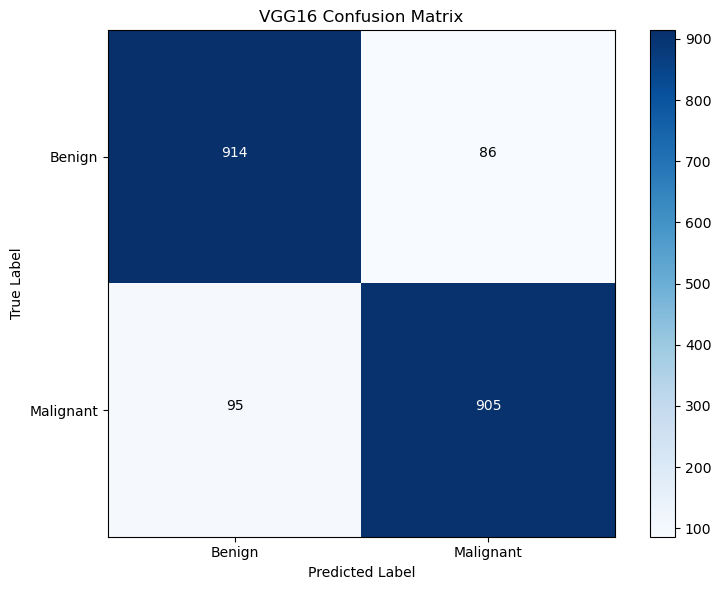

In [49]:
# Print the classification report
print("VGG16 Classification Report:")
print(classification_report(true_classes, VGG16_predicted_classes))

# Plot the confusion matrix
VGG16_cm = confusion_matrix(true_classes, VGG16_predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(VGG16_cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('VGG16 Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Benign', 'Malignant'])
plt.yticks(tick_marks, ['Benign', 'Malignant'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add the values inside the squares
thresh = VGG16_cm.max() / 2.
for i in range(VGG16_cm.shape[0]):
    for j in range(VGG16_cm.shape[1]):
        plt.text(j, i, format(VGG16_cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if VGG16_cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

Classification matrix reveals that the hybrid model is quite balanced at differentiating between Malignant and Benign Melanoma. Overall the hybrid model has proven to be very effective and well balanced at determining if a Melanoma spot is Benign or Malignant. The only issue with this model is the significant number of layers, making the processing time very long.

In [50]:
VGG16_model.save('VGG16_model.keras')
VGG16_model.save('VGG16_model.h5')

## Model 3: Basic Sequential model

The Sequential model is a basic CNN model that I attempted to construct using the help of Claude 3.0 Opus. I consists of 8 layers, which are 3 Conv2D, 2 MaxPooling2D, 1 Flatten and 2 Dense layers.

In [51]:
img_size = (128,128)

# Create the CNN cnn_model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size[0], img_size[1], 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='sigmoid')
])

# Compile the cnn_model
cnn_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

c:\Users\Ryany\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [52]:
# Train the model
cnn_history = cnn_model.fit(train_generator,
          batch_size = batch_size,
          epochs=10,
          validation_data=val_generator,)

Epoch 1/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 308s 1s/step - accuracy: 0.7570 - loss: 0.6950 - val_accuracy: 0.8178 - val_loss: 0.3879
Epoch 2/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 294s 979ms/step - accuracy: 0.8270 - loss: 0.3861 - val_accuracy: 0.8136 - val_loss: 0.3912
Epoch 3/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 301s 1s/step - accuracy: 0.8371 - loss: 0.3601 - val_accuracy: 0.8426 - val_loss: 0.3703
Epoch 4/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 301s 1s/step - accuracy: 0.8489 - loss: 0.3550 - val_accuracy: 0.8220 - val_loss: 0.4060
Epoch 5/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 296s 985ms/step - accuracy: 0.8453 - loss: 0.3640 - val_accuracy: 0.8354 - val_loss: 0.3930
Epoch 6/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 312s 1s/step - accuracy: 0.8542 - loss: 0.3311 - val_accuracy: 0.8552 - val_loss: 0.3370
Epoch 7/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 304s 1s/step - accuracy: 0.8558 - loss: 0.3345 - val_accuracy: 0.8468 - val_loss: 0.3383
Epoch 8/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 295s 982ms/step - accuracy: 0.8581 - loss: 0.3228 -

In [53]:
# Generate predictions on the test set
test_generator.reset()
steps = math.ceil(test_generator.samples / test_generator.batch_size)
cnn_predictions = cnn_model.predict(test_generator, steps=steps)
cnn_predicted_classes = np.argmax(cnn_predictions, axis=1)

# Get the true labels from the test generator
true_classes = test_generator.classes


63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 169ms/step


In [54]:
# Evaluate the model on the test set
test_loss, test_accuracy = cnn_model.evaluate(test_generator)

# Print the test accuracy
print("Test Accuracy:", test_accuracy)

63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 178ms/step - accuracy: 0.8695 - loss: 0.3104
Test Accuracy: 0.8845000267028809


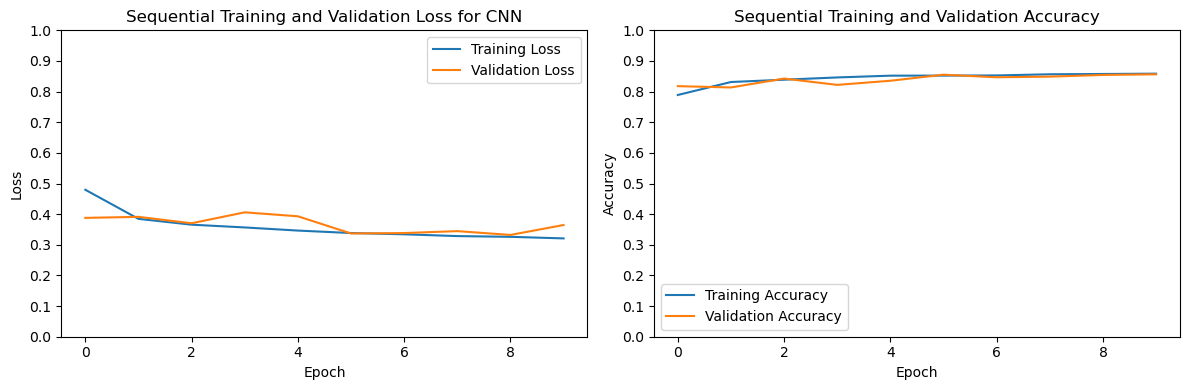

In [55]:
# Plot the training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['loss'], label='Training Loss')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 1)
plt.yticks([i/10 for i in range(11)]) 
plt.legend()
plt.title('Sequential Training and Validation Loss for CNN')

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['accuracy'], label='Training Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.yticks([i/10 for i in range(11)]) 
plt.legend()
plt.title('Sequential Training and Validation Accuracy')

plt.tight_layout()
plt.show()

Sequential Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.87      0.88      1000
           1       0.87      0.90      0.89      1000

    accuracy                           0.88      2000
   macro avg       0.88      0.88      0.88      2000
weighted avg       0.88      0.88      0.88      2000



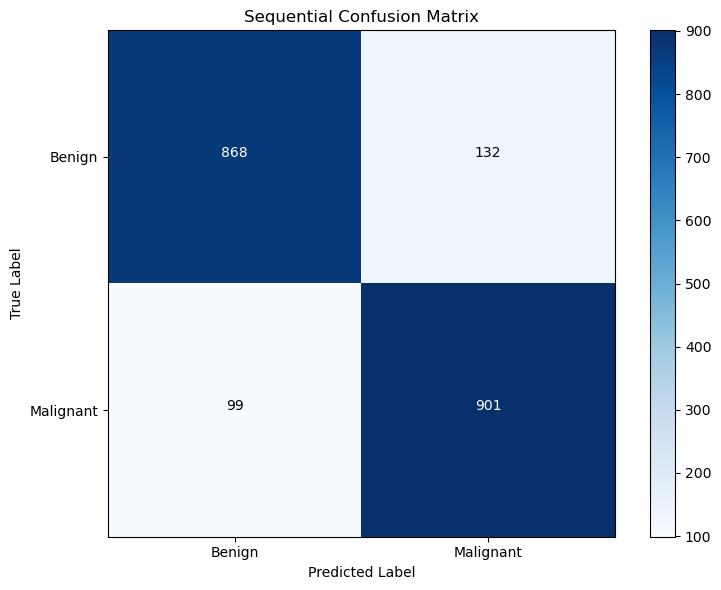

In [56]:
# Print the classification report
print("Sequential Classification Report:")
print(classification_report(true_classes, cnn_predicted_classes))

# Plot the confusion matrix
cnn_cm = confusion_matrix(true_classes, cnn_predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cnn_cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Sequential Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Benign', 'Malignant'])
plt.yticks(tick_marks, ['Benign', 'Malignant'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add the values inside the squares
thresh = cnn_cm.max() / 2.
for i in range(cnn_cm.shape[0]):
    for j in range(cnn_cm.shape[1]):
        plt.text(j, i, format(cnn_cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cnn_cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

In [57]:
cnn_model.save('cnn_model.keras')
cnn_model.save('cnn_model.h5')

Overall the Sequential model proved to be equally effective, slightly worse than the Hybrid model but well balanced with a bias towards False Positives over False Negatives, which is preferred in the context of the classifier. The main standing out point would be its processing time, which was the fastest amongst all the models.

In [58]:
# Set the path to your image dataset
train_data = '../data/train'
test_data = '../data/test'
# Set the desired image size for resizing
img_size = (128, 128)

# Load the image data and labels
X = []
y = []
X_validation_test = []
y_validation_test = []

for class_dir in os.listdir(train_data):
    class_path = os.path.join(train_data, class_dir)
    if os.path.isdir(class_path):
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            img = imread(img_path)
            img = resize(img, img_size)
            X.append(img.flatten())
            y.append(class_dir)

for class_dir in os.listdir(test_data):
    class_path = os.path.join(test_data, class_dir)
    if os.path.isdir(class_path):
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            img = imread(img_path)
            img = resize(img, img_size)
            X_validation_test.append(img.flatten())
            y_validation_test.append(class_dir)

X = np.array(X)
y = np.array(y)

X_validation_test = np.array(X_validation_test)
y_validation_test = np.array(y_validation_test)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the SVM model
svm_model = SVC(kernel='rbf', C=1.0, random_state=42)

# Train the SVM model
svm_history = svm_model.fit(X_train, y_train)


SVM Classification Report:
              precision    recall  f1-score   support

      Benign       0.87      0.92      0.90      1000
   Malignant       0.92      0.87      0.89      1000

    accuracy                           0.90      2000
   macro avg       0.90      0.90      0.89      2000
weighted avg       0.90      0.90      0.89      2000



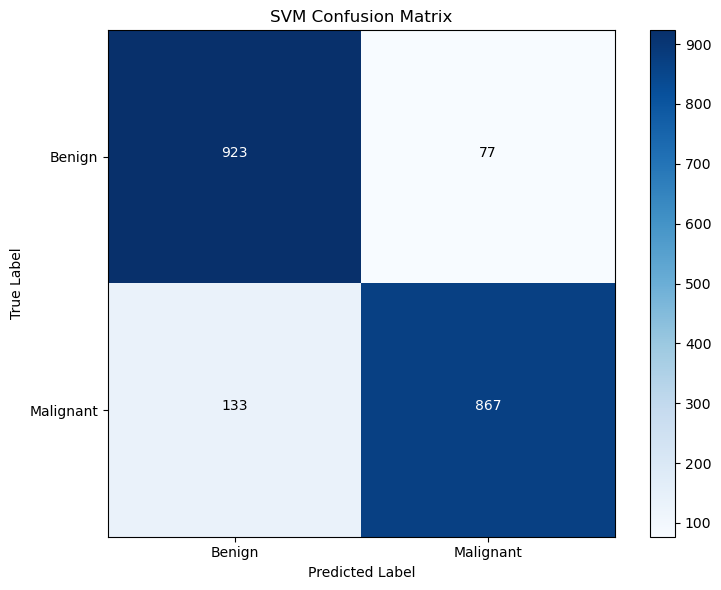

In [66]:
# Make predictions on the test set
y_pred = svm_model.predict(X_validation_test)

# Print the classification report
print("SVM Classification Report:")
print(classification_report(y_validation_test, y_pred))

# Plot the confusion matrix
svm_cm = confusion_matrix(y_validation_test, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(svm_cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('SVM Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, ['Benign', 'Malignant'])
plt.yticks(tick_marks, ['Benign', 'Malignant'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')


# Add the values inside the squares
thresh = svm_cm.max() / 2.
for i in range(svm_cm.shape[0]):
    for j in range(svm_cm.shape[1]):
        plt.text(j, i, format(svm_cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if svm_cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

SVM was used as a litmus test to see if the problem was best tackled with a Neural Network or not. The results however surprised me in that SVM performed decently well at classifying the data. However, it did take a long time and was not as accurate at other Neural Networks, so taking that into consideration, SVM will not be chosen as the final model.

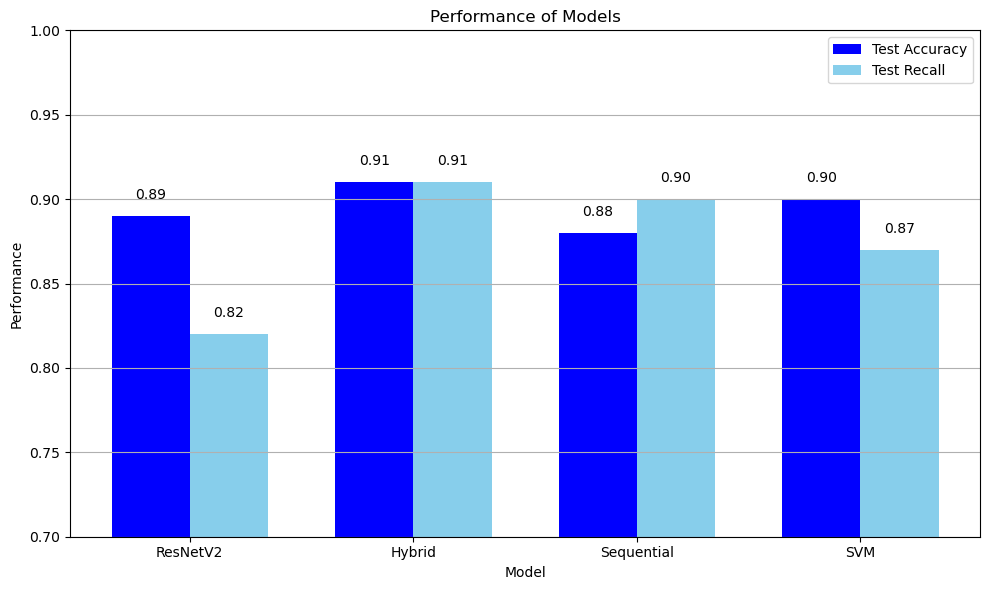

In [10]:
model_names = ['ResNetV2', 'Hybrid', 'Sequential', 'SVM']
test_accuracies = [0.89, 0.91, 0.88, 0.90]
test_recall = [0.82, 0.91, 0.90, 0.87]  # Example recall values

# Create bar chart
plt.figure(figsize=(10, 6))  # Adjusting figure size
bar_width = 0.35  # Width of each bar

# Plot test accuracies
plt.bar([i - bar_width/2 for i in range(len(model_names))], test_accuracies, bar_width, color='blue', label='Test Accuracy')

# Plot test recall
plt.bar([i + bar_width/2 for i in range(len(model_names))], test_recall, bar_width, color='skyblue', label='Test Recall')

# Add labels and title
plt.xlabel('Model')
plt.ylabel('Performance')
plt.title('Performance of Models')
plt.ylim(0.7, 1)  # Set y-axis range from 0 to 1
plt.xticks(range(len(model_names)), model_names)  # Set x-tick labels
plt.grid(axis='y')  # Add grid lines on y-axis
plt.legend()  # Add legend

# Show values on top of bars for test accuracies
for i, accuracy in enumerate(test_accuracies):
    plt.text(i - bar_width/2, accuracy + 0.01, f'{accuracy:.2f}', ha='center')

# Show values on top of bars for test recall
for i, recall in enumerate(test_recall):
    plt.text(i + bar_width/2, recall + 0.01, f'{recall:.2f}', ha='center')

plt.tight_layout()
plt.show()


## Conclusion

In conclusion, the above 5 models show that the Hybrid model proved to be the most accurate and well balanced model, showing an effective 91% in both test accuracy and recall. However, when factoring processing time into account, Sequential showed to be the least time intensive. Being able to fit completely within 50 minutes, it can be concluded that for the time-span of this project, Sequential will be used moving forward for tuning.